In [1]:
import torch
import pyro
import pyro.distributions as dist

In [2]:
# Model
def scale(guess):
    weight = pyro.sample('weight', dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

# Conditioned model
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

# Posterior approx
def scale_parametrized_guide_constrained(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.), constraint=torch.distributions.constraints.positive)
    return pyro.sample('weight', dist.Normal(a, b))

print('m={}; cm={}; g={}'.format(
    scale(10.), conditioned_scale(10.), scale_parametrized_guide_constrained(10.)
))

m=9.523226737976074; cm=9.5; g=9.432055473327637


In [3]:
import pyro.infer
import pyro.optim

pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned_scale,
    guide=scale_parametrized_guide_constrained,
    optim=pyro.optim.SGD({'lr': 0.001, 'momentum':0.1}),
    loss=pyro.infer.Trace_ELBO()
)

In [4]:
losses, a, b  = [], [], []
guess = 10.

for _ in range(1000):
    losses.append(svi.step(guess))
    a.append(pyro.param('a').item())
    b.append(pyro.param('b').item())
    
print('weights loc={} & scale={}'.format(a[-1], b[-1]))

weights loc=9.735331535339355 & scale=0.6032806038856506


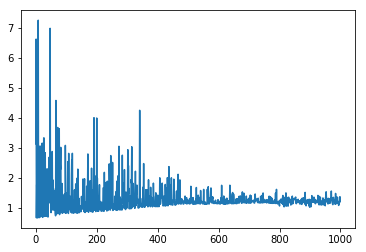

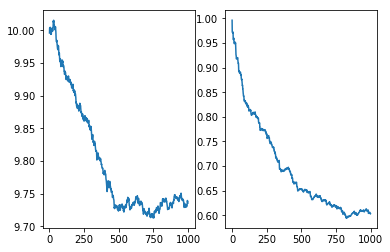

In [6]:
from matplotlib import pyplot

fig, ax = pyplot.subplots()
ax.plot(losses)

fig, axs = pyplot.subplots(ncols=2, nrows=1)

axs[0].plot(a, label='loc')
axs[1].plot(b, label='scale')